In [1]:
!pip install geneticalgorithm

In [2]:
#Import required libraries
import pandas as pd
import numpy as np
from datetime import datetime 
from geneticalgorithm import geneticalgorithm as ga
from scipy.optimize import  differential_evolution
import matplotlib.pyplot as plt
import math
import os

In [3]:
#Specify current directory and input/output paths
path = os.getcwd() #Get current directory
energy_input_path = path + r'\sample data\energy' #Specify directory for energy data
weather_input_path = path + r'\sample data\weather' #Specify directory for weather data
output_path = path + r'\output' #Specify output directory for KPIs and visualizations

In [4]:
#Read energy data files
energy_files = os.listdir(energy_input_path)
energy_files_csv = [f for f in energy_files if f[-3:] == 'csv']
energy = pd.read_csv(energy_input_path + '\\' + energy_files_csv[0])

#Read AMY weather data
weather_files = os.listdir(weather_input_path)
weather_files_csv = [f for f in weather_files if f[-3:] == 'csv']
weather = pd.read_csv(weather_input_path + '\\' + weather_files_csv[0],usecols=[3],skiprows=18)

In [5]:
#Define ga functions

def rmse_heatingChangePoint(x): #Heating model
  
  sch = ((df.index.hour > x[4]) & (df.index.hour < x[5]) & (df.index.dayofweek >=0 ) & (df.index.dayofweek < 5)) | ((df.index.hour> x[6]) & (df.index.hour < x[7]) & ( (df.index.dayofweek==6) | (df.index.dayofweek == 5)))
  yp = (np.logical_and(tOa < x[2] , sch == 1 )) * ((x[2] - tOa) * x[0] + x[3]) + (np.logical_and(tOa < x[2] , sch == 0 ))*((x[2] - tOa) * x[1] + x[3]) + (tOa >= x[2])*x[3]

  rmse = np.sqrt(((yp - qHtg) ** 2).mean())

  return rmse

def rmse_coolingChangePoint(x): #Cooling model
  
  sch = ((df.index.hour > x[4]) & (df.index.hour < x[5]) & (df.index.dayofweek >=0 ) & (df.index.dayofweek < 5)) | ((df.index.hour> x[6]) & (df.index.hour < x[7]) & ( (df.index.dayofweek==6) | (df.index.dayofweek == 5)))

  yp = (np.logical_and(tOa >= x[2] , sch == 1 )) * ((tOa - x[2]) * x[0] + x[3]) + (np.logical_and(tOa >= x[2] , sch == 0 ))*((tOa - x[2]) * x[1] + x[3]) + (tOa < x[2])*x[3]

  rmse = np.sqrt(((yp - qClg) ** 2).mean())
 
  return rmse

def rmse_electricityChangePoint(x):#Electricity model
  
  sch = ((df.index.hour > x[4]) & (df.index.hour < x[5]) & (df.index.dayofweek >=0 ) & (df.index.dayofweek < 5)) | ((df.index.hour> x[6]) & (df.index.hour < x[7]) & ( (df.index.dayofweek==6) | (df.index.dayofweek == 5)))

  yp = (np.logical_and(tOa >= x[2] , sch == 1 )) * ((tOa - x[2]) * x[0] + x[3]) + (np.logical_and(tOa >= x[2] , sch == 0 ))*((tOa - x[2]) * x[1] + x[3]) + (tOa < x[2])*x[3]

  rmse = np.sqrt(((yp - qElec) ** 2).mean())

  return rmse

In [6]:

#Extract energy use and outdoor air temps from read files
qHtg = energy[energy.columns[3]]
qClg = energy[energy.columns[2]]
qElec = energy[energy.columns[1]]
tOa = weather[weather.columns[0]]

#Create one dataframe to store all relevant data
df = pd.DataFrame()
df['heating'] = qHtg
df['cooling'] = qClg
df['electricity'] = qElec
df.index = energy[energy.columns[0]]
df.index = pd.to_datetime(df.index)
df['timeOfDay'] = df.index.hour
df['dayOfWeek'] = df.index.dayofweek
# x[0] primary slope workhours
# x[1] secondary slope afterhours
# x(3) x-coordinate of change point
# x(4) y-coordinate of change point
# x(5) start time of day (for weekdays)
# x(6) stop time of day (for weekday)
# x(7) start time of day (for weekends)
# x(8) stop time of day (for weekends)

 The best solution found:
 [ 9.79305925  5.90116493 14.62144638 12.47119731  7.17277817 22.71804215
  9.98645193 15.94143402]

 Objective function:
 42.607337513287646


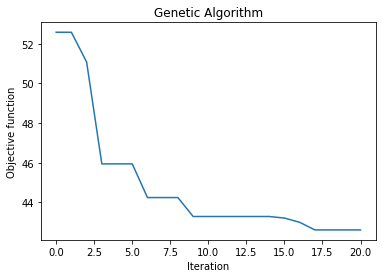

In [7]:
varbound = np.array([[0, max(qHtg)/10],[0,max(qHtg)/10],[0,20],[0,max(qHtg)],[0,8],[16,23],[0,12],[12,23]])

algorithm_param = {'max_num_iteration': 20,\
                   'population_size':5000,\
                   'mutation_probability':0.1,\
                   'elit_ratio': 0.01,\
                   'crossover_probability': 0.7,\
                   'parents_portion': 0.3,\
                   'crossover_type':'uniform',\
                   'max_iteration_without_improv':10}

model_Htg_GA = ga(function=rmse_heatingChangePoint,
                  dimension=8, 
                  variable_type='real', 
                  variable_boundaries = varbound,
                  algorithm_parameters=algorithm_param)

model_Htg_GA.run()
result = differential_evolution(rmse_heatingChangePoint, varbound)

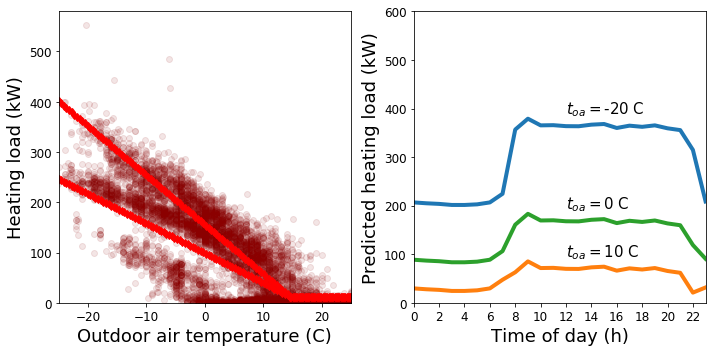

In [8]:
fval = model_Htg_GA.best_function
x = model_Htg_GA.best_variable
sch = ((df.index.hour > x[4]) & (df.index.hour < x[5]) & (df.index.dayofweek >=0 ) & (df.index.dayofweek < 5)) | ((df.index.hour> x[6]) & (df.index.hour < x[7]) & ( (df.index.dayofweek==6) | (df.index.dayofweek == 5)))
yp = (np.logical_and(tOa < x[2] , sch == 1 )) * ((x[2] - tOa) * x[0] + x[3]) + (np.logical_and(tOa < x[2] , sch == 0 ))*((x[2] - tOa) * x[1] + x[3]) + (tOa >= x[2])*x[3]
residuals = qHtg - yp
timeOfDay_handle = df.index.hour
mdl_heating_prmtr = x
mdl_heating_cvrmse = fval/qHtg.mean()*(100)

a=[]
b=[]

for i in range(0,24):
  a.append(residuals[(timeOfDay_handle == i) & ((df.index.dayofweek >= 0) & (df.index.dayofweek < 5)) & (tOa < x[2])].mean())
  b.append(residuals[(timeOfDay_handle == i) & ((df.index.dayofweek >= 0) & (df.index.dayofweek < 5)) & (tOa >= x[2])].mean())

mdl_heating_residual= pd.DataFrame(a,columns=['residual1'])
mdl_heating_residual['residual2'] = b

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.scatter(tOa, qHtg, alpha=0.1, c='darkred')
plt.xlabel('Outdoor air temperature (C)',fontsize = 18)
plt.ylabel("Heating load (kW)", fontsize= 18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(-25,25)
plt.ylim(bottom=0)

# cold operating hours
tOa_handle = np.linspace(-30,x[2],100)
sch_handle = np.ones(len(tOa_handle))
yp = (np.logical_and(tOa_handle < x[2] , sch_handle== 1 )) * ((x[2] - tOa_handle) * x[0] + x[3]) + (np.logical_and(tOa_handle < x[2] , sch_handle == 0 ))*((x[2] - tOa_handle) * x[1] + x[3]) + (tOa_handle >= x[2])*x[3]
plt.plot(tOa_handle,yp, 'dr')

# cold afterhours
sch_handle = np.zeros(len(tOa_handle))
yp = (np.logical_and(tOa_handle < x[2] , sch_handle== 1 )) * ((x[2] - tOa_handle) * x[0] + x[3]) + (np.logical_and(tOa_handle < x[2] , sch_handle == 0 ))*((x[2] - tOa_handle) * x[1] + x[3]) + (tOa_handle >= x[2])*x[3]
plt.plot(tOa_handle,yp, 'dr')

#warm hours
tOa_handle = np.linspace(x[2],35,100)
yp = (np.logical_and(tOa_handle < x[2] , sch_handle== 1 )) * ((x[2] - tOa_handle) * x[0] + x[3]) + (np.logical_and(tOa_handle < x[2] , sch_handle == 0 ))*((x[2] - tOa_handle) * x[1] + x[3]) + (tOa_handle >= x[2])*x[3]
plt.plot(tOa_handle,yp, 'dr')


plt.subplot(122)
plt.xlim(0,23)
plt.ylim(0 ,math.ceil(max(qHtg)/100)*100)
plt.xticks(np.arange(0, 24, step=2), fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Time of day (h)',fontsize = 18)
plt.ylabel("Predicted heating load (kW)", fontsize= 18)
timeOfDay_handle = list(range(0,24))
sch_handle =((timeOfDay_handle > x[4]) & (timeOfDay_handle < x[5] ))

for i in [-20,10,0]:
  tOa_handle = i*(np.ones(len(timeOfDay_handle)))
  yp = (np.logical_and(tOa_handle < x[2] , sch_handle== 1 )) * ((x[2] - tOa_handle) * x[0] + x[3]) + (np.logical_and(tOa_handle < x[2] , sch_handle == 0 ))*((x[2] - tOa_handle) * x[1] + x[3]) + (tOa_handle >= x[2])*x[3]
  if i < x[2]:
    yp = np.maximum(yp + mdl_heating_residual['residual1'].values,0)
  else:
    yp = np.maximum(yp + mdl_heating_residual['residual2'].values,0)

  plt.plot(timeOfDay_handle, yp, linewidth=4, markersize=16)
  plt.text(x=12,y=max(yp)+10,s=r'$t_{oa} =$' + str(i) + ' C', fontsize=15)

plt.tight_layout()
plt.savefig(output_path + r'\energyBase_heating.png',dpi=600)


 The best solution found:
 [15.47117133  3.86351346 13.1506609   4.6234997   5.17658676 19.98295363
  6.32847431 15.51032119]

 Objective function:
 34.32360208097689


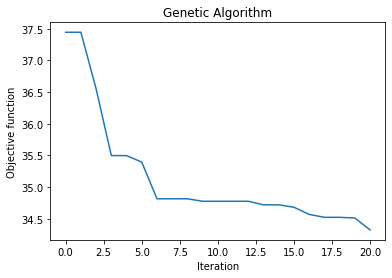

In [9]:
varbound = np.array([[0, max(qClg)/10],[0,max(qClg)/10],[0,20],[0,max(qClg)],[0,8],[16,23],[0,12],[12,23]])

model_Clg_GA = ga(function=rmse_coolingChangePoint,
                  dimension=8, 
                  variable_type='real', 
                  variable_boundaries = varbound,
                  algorithm_parameters=algorithm_param) #Use the same parameters as previous ga

model_Clg_GA.run()
result = differential_evolution(rmse_coolingChangePoint, varbound)

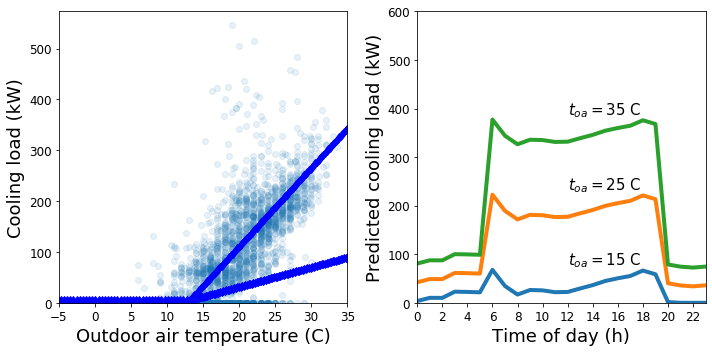

In [10]:
fval_Clg = model_Clg_GA.best_function
x = model_Clg_GA.best_variable
sch = ((df.index.hour > x[4]) & (df.index.hour < x[5]) & (df.index.dayofweek >=0 ) & (df.index.dayofweek < 5)) | ((df.index.hour> x[6]) & (df.index.hour < x[7]) & ( (df.index.dayofweek==6) | (df.index.dayofweek == 5)))
yp = (np.logical_and(tOa >= x[2] , sch == 1 )) * ((tOa - x[2]) * x[0] + x[3]) + (np.logical_and(tOa >= x[2] , sch == 0 ))*((tOa - x[2]) * x[1] + x[3]) + (tOa < x[2])*x[3]
residuals = qClg - yp
timeOfDay_handle = df.index.hour
mdl_cooling_prmtr = x
mdl_cooling_cvrmse = fval_Clg/qClg.mean()*(100)

a=[]
b=[]

for i in range(0,24):
  a.append(residuals[(timeOfDay_handle == i) & ((df.index.dayofweek >= 0) & (df.index.dayofweek < 5)) & (tOa < x[2])].mean())
  b.append(residuals[(timeOfDay_handle == i) & ((df.index.dayofweek >= 0) & (df.index.dayofweek < 5)) & (tOa >= x[2])].mean())

mdl_cooling_residual= pd.DataFrame(a,columns=['residual1'])
mdl_cooling_residual['residual2'] = b

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.scatter(tOa, qClg, alpha=0.1)
plt.xlabel('Outdoor air temperature (C)',fontsize = 18)
plt.ylabel("Cooling load (kW)", fontsize= 18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(-5,35)
plt.ylim(bottom=0)

# hot operating hours
tOa_handle = np.linspace(x[2],35,100)
sch_handle = np.ones(len(tOa_handle))
yp = (np.logical_and(tOa_handle >= x[2] , sch_handle == 1 )) * ((tOa_handle - x[2]) * x[0] + x[3]) + (np.logical_and(tOa_handle >= x[2] , sch_handle == 0 ))*((tOa_handle - x[2]) * x[1] + x[3]) + (tOa_handle < x[2])*x[3]
plt.plot(tOa_handle,yp, 'db')

# hot afterhours
sch_handle = np.zeros(len(tOa_handle))
yp = (np.logical_and(tOa_handle >= x[2] , sch_handle == 1 )) * ((tOa_handle - x[2]) * x[0] + x[3]) + (np.logical_and(tOa_handle >= x[2] , sch_handle == 0 ))*((tOa_handle - x[2]) * x[1] + x[3]) + (tOa_handle < x[2])*x[3]
plt.plot(tOa_handle,yp, 'db')

#cool hours
tOa_handle = np.linspace(-30,x[2],100)
yp = (np.logical_and(tOa_handle >= x[2] , sch_handle == 1 )) * ((tOa_handle - x[2]) * x[0] + x[3]) + (np.logical_and(tOa_handle >= x[2] , sch_handle == 0 ))*((tOa_handle - x[2]) * x[1] + x[3]) + (tOa_handle < x[2])*x[3]
plt.plot(tOa_handle,yp, 'db')

plt.subplot(122)
plt.xlim(0,23)
plt.ylim(0 ,math.ceil(max(qClg)/100)*100)
plt.xticks(np.arange(0,24 ,step=2), fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Time of day (h)',fontsize = 18)
plt.ylabel("Predicted cooling load (kW)", fontsize= 18)
timeOfDay_handle = list(range(0,24))
sch_handle =((timeOfDay_handle > x[4]) & (timeOfDay_handle < x[5] ))

for i in [15,25,35]:
  tOa_handle = i*(np.ones(len(timeOfDay_handle)))
  yp = (np.logical_and(tOa_handle >= x[2] , sch_handle == 1 )) * ((tOa_handle - x[2]) * x[0] + x[3]) + (np.logical_and(tOa_handle >= x[2] , sch_handle == 0 ))*((tOa_handle - x[2]) * x[1] + x[3]) + (tOa_handle < x[2])*x[3]
  if i < x[2]:
    yp = np.maximum(yp + mdl_cooling_residual['residual1'].values,0)
  else:
    yp = np.maximum(yp + mdl_cooling_residual['residual2'].values,0)
  
  plt.plot(timeOfDay_handle, yp, linewidth=4, markersize=16)
  plt.text(x=12, y=max(yp)+10, s=r'$t_{oa} =$' + str(i) + ' C', fontsize=15)

plt.tight_layout()
plt.savefig(output_path + r'\energyBase_cooling.png',dpi=600)


 The best solution found:
 [ 12.65065081  10.34711848   4.18357391 121.34067523   6.23780714
  20.74396567  11.29382035  12.63987175]

 Objective function:
 44.883792476524896


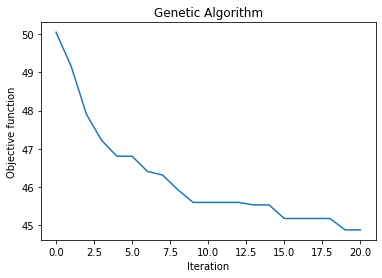

In [11]:
varbound = np.array([[0, max(qElec)/10],[0,max(qElec)/10],[0,20],[0,max(qElec)],[0,8],[16,23],[0,12],[12,23]])

model_Elec_GA = ga(function=rmse_electricityChangePoint,
                    dimension=8, 
                    variable_type='real', 
                    variable_boundaries = varbound,
                    algorithm_parameters=algorithm_param) #Use the same parameters as previous ga

model_Elec_GA.run()
result = differential_evolution(rmse_electricityChangePoint, varbound)

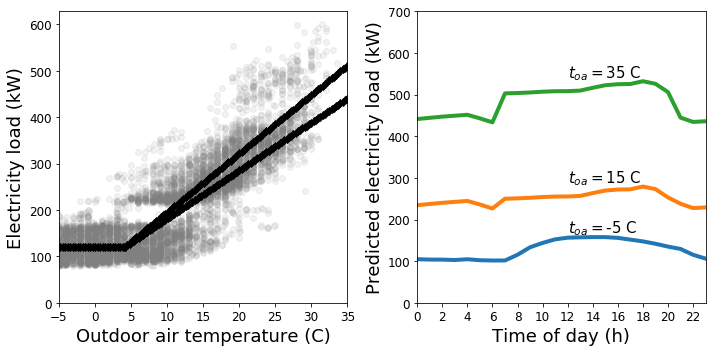

In [12]:
fval_Elec = model_Elec_GA.best_function
x = model_Elec_GA.best_variable
sch = ((df.index.hour > x[4]) & (df.index.hour < x[5]) & (df.index.dayofweek >=0 ) & (df.index.dayofweek < 5)) | ((df.index.hour> x[6]) & (df.index.hour < x[7]) & ( (df.index.dayofweek==6) | (df.index.dayofweek == 5)))
yp = (np.logical_and(tOa >= x[2] , sch == 1 )) * ((tOa - x[2]) * x[0] + x[3]) + (np.logical_and(tOa >= x[2] , sch == 0 ))*((tOa - x[2]) * x[1] + x[3]) + (tOa < x[2])*x[3]
residuals = qElec - yp
timeOfDay_handle = df.index.hour
mdl_electricity_prmtr = x
mdl_electricity_cvrmse = fval_Elec/qElec.mean()*(100)

a=[]
b=[]

for i in range(0,24):
  a.append(residuals[(timeOfDay_handle == i) & ((df.index.dayofweek >= 0) & (df.index.dayofweek < 5)) & (tOa < x[2])].mean())
  b.append(residuals[(timeOfDay_handle == i) & ((df.index.dayofweek >= 0) & (df.index.dayofweek < 5)) & (tOa >= x[2])].mean())

mdl_electricity_residual= pd.DataFrame(a,columns=['residual1'])
mdl_electricity_residual['residual2'] = b

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.scatter(tOa, qElec, alpha=0.1, c='gray')
plt.xlabel('Outdoor air temperature (C)',fontsize = 18)
plt.ylabel("Electricity load (kW)", fontsize= 18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(-5,35)
plt.ylim(bottom=0)

# hot operating hours
tOa_handle = np.linspace(x[2],35,100)
sch_handle = np.ones(len(tOa_handle))
yp = (np.logical_and(tOa_handle >= x[2] , sch_handle == 1 )) * ((tOa_handle - x[2]) * x[0] + x[3]) + (np.logical_and(tOa_handle >= x[2] , sch_handle == 0 ))*((tOa_handle - x[2]) * x[1] + x[3]) + (tOa_handle < x[2])*x[3]
plt.plot(tOa_handle,yp, 'dk')

# hot afterhours
sch_handle = np.zeros(len(tOa_handle))
yp = (np.logical_and(tOa_handle >= x[2] , sch_handle == 1 )) * ((tOa_handle - x[2]) * x[0] + x[3]) + (np.logical_and(tOa_handle >= x[2] , sch_handle == 0 ))*((tOa_handle - x[2]) * x[1] + x[3]) + (tOa_handle < x[2])*x[3]
plt.plot(tOa_handle,yp, 'dk')

#cool hours
tOa_handle = np.linspace(-30,x[2],100)
yp = (np.logical_and(tOa_handle >= x[2] , sch_handle == 1 )) * ((tOa_handle - x[2]) * x[0] + x[3]) + (np.logical_and(tOa_handle >= x[2] , sch_handle == 0 ))*((tOa_handle - x[2]) * x[1] + x[3]) + (tOa_handle < x[2])*x[3]
plt.plot(tOa_handle,yp, 'dk')


plt.subplot(122)
plt.xlim(0,23)
plt.ylim(0 ,math.ceil(max(qElec)/100)*100)
plt.xticks(np.arange(0,24 ,step=2), fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Time of day (h)',fontsize = 18)
plt.ylabel("Predicted electricity load (kW)", fontsize= 18)
timeOfDay_handle = list(range(0,24))
sch_handle =((timeOfDay_handle > x[4]) & (timeOfDay_handle < x[5]))

for i in [-5,15,35]:
  tOa_handle = i*(np.ones(len(timeOfDay_handle)))
  yp = (np.logical_and(tOa_handle >= x[2] , sch_handle == 1 )) * ((tOa_handle - x[2]) * x[0] + x[3]) + (np.logical_and(tOa_handle >= x[2] , sch_handle == 0 ))*((tOa_handle - x[2]) * x[1] + x[3]) + (tOa_handle < x[2])*x[3]
  if i < x[2]:
    yp = np.maximum(yp + mdl_electricity_residual['residual1'].values,0)
  else:
    yp = np.maximum(yp + mdl_electricity_residual['residual2'].values,0)
  
  plt.plot(timeOfDay_handle, yp, linewidth=4, markersize=16)
  plt.text(x=12, y=max(yp)+10, s=r'$t_{oa} =$' + str(i) + ' C', fontsize=15)

plt.tight_layout()
plt.savefig(output_path + r'\energyBase_electricity.png',dpi=600)


In [13]:
kpi_scheduleEffectiveness_heating = 1-(mdl_heating_prmtr[1]/mdl_heating_prmtr[0])
kpi_scheduleEffectiveness_cooling = 1-(mdl_cooling_prmtr[1]/mdl_cooling_prmtr[0])
kpi_scheduleEffectiveness_electricity = 1-(mdl_electricity_prmtr[1]/mdl_electricity_prmtr[0])
x = mdl_heating_prmtr
sch = ((df.index.hour > x[4]) & (df.index.hour < x[5]) & (df.index.dayofweek >=0 ) & (df.index.dayofweek < 5)) | ((df.index.hour> x[6]) & (df.index.hour < x[7]) & ( (df.index.dayofweek==6) | (df.index.dayofweek == 5)))
kpi_afterHoursEnergyFraction_heating = 1 - (qHtg[sch]).sum()/qHtg.sum()
    
x = mdl_cooling_prmtr
sch = ((df.index.hour > x[4]) & (df.index.hour < x[5]) & (df.index.dayofweek >=0 ) & (df.index.dayofweek < 5)) | ((df.index.hour> x[6]) & (df.index.hour < x[7]) & ( (df.index.dayofweek==6) | (df.index.dayofweek == 5)))

kpi_afterHoursEnergyFraction_cooling = 1 - sum(qClg[sch])/sum(qClg)
x = mdl_electricity_prmtr
sch = ((df.index.hour > x[4]) & (df.index.hour < x[5]) & (df.index.dayofweek >=0 ) & (df.index.dayofweek < 5)) | ((df.index.hour> x[6]) & (df.index.hour < x[7]) & ( (df.index.dayofweek==6) | (df.index.dayofweek == 5)))
kpi_afterHoursEnergyFraction_electricity = 1 - sum(qElec[sch])/sum(qElec)

#Output an excel table with KPIs
d = {'Utility': ['Heating', 'Cooling','Electricity'],
     'Schedule Effectivness': [kpi_scheduleEffectiveness_heating, kpi_scheduleEffectiveness_cooling,kpi_scheduleEffectiveness_electricity],
     'After-hours energy use ratio':[kpi_afterHoursEnergyFraction_heating,kpi_afterHoursEnergyFraction_cooling,kpi_afterHoursEnergyFraction_electricity]}
kpi_df = pd.DataFrame(data=d)

writer = pd.ExcelWriter(output_path + r'\energyBase_summary.xlsx', engine='xlsxwriter')
kpi_df.to_excel(writer, sheet_name='KPIs')
writer.save()
